# Рекомендация тарифов

Данные: данные о поведении клиентов, которые уже перешли на тарифы. 

**Цель исследования** — построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится. Мерка качества *accuracy* (довести долю правильных ответов минимум до 0.75).

**План работы:** 
1. Импорт данных.

2. Обзор данных.

3. Построение модели для задачи классификации с accuracy не менее 0.75
 
4. Проверка *accuracy* на тестовой выборке.

## Импорт и изучение данных:

Импортировала все библиотеки, которые могут понадобиться:

In [9]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [10]:
# Прочитаем файл: 
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

Изучение данных:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Так как предобработка уже была проведена, в ней нет нужды.

## Разбиение данных на выборки:

In [12]:
# Сначала отделим целевой признак:
features = df.drop(columns = ['is_ultra'])
target = df['is_ultra']

In [13]:
# Поделим датасет на тренировочную, валидационную и тестовую выборки: 
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

## Исследование модели:

Возьмем два алгоритма - простое дерево и случайное дерево.

Выведем сразу accuracy с оптимальными гиперпараметрами:

In [15]:
s_model = None
s_result = 0
s_est = 0
s_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        accuracy = accuracy_score(target_valid, predictions_valid) 
        if accuracy > s_result:
            s_model = model
            s_result = accuracy
            s_est = est
            s_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", s_result, "Максимальная глубина:", depth)

RMSE наилучшей модели на валидационной выборке: 0.7993779160186625 Максимальная глубина: 10


In [16]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
gparms_tree = pd.DataFrame({'max_depth' :[], 'accuracy' :[]}) #таблица для сравнения точности при изменении макс.доп.глубины
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        accuracy = accuracy_score(target_valid, predictions_valid)
        gparms_tree.loc[len(gparms_tree.index)] = [depth, accuracy]
        if accuracy > best_result:
            best_model = model
            best_result = accuracy
            best_est = est
            best_depth = depth

print("Доля правильных ответов наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

Доля правильных ответов наилучшей модели на валидационной выборке: 0.8133748055987559 Количество деревьев: 10 Максимальная глубина: 10


Наилучшая модель - RandomForestClassifier, с количеством деревьев - 10, и с максимальной глубиной 10. Так как accuracy выше всего (0.82).

Нарисую график, который покажет зависимость:

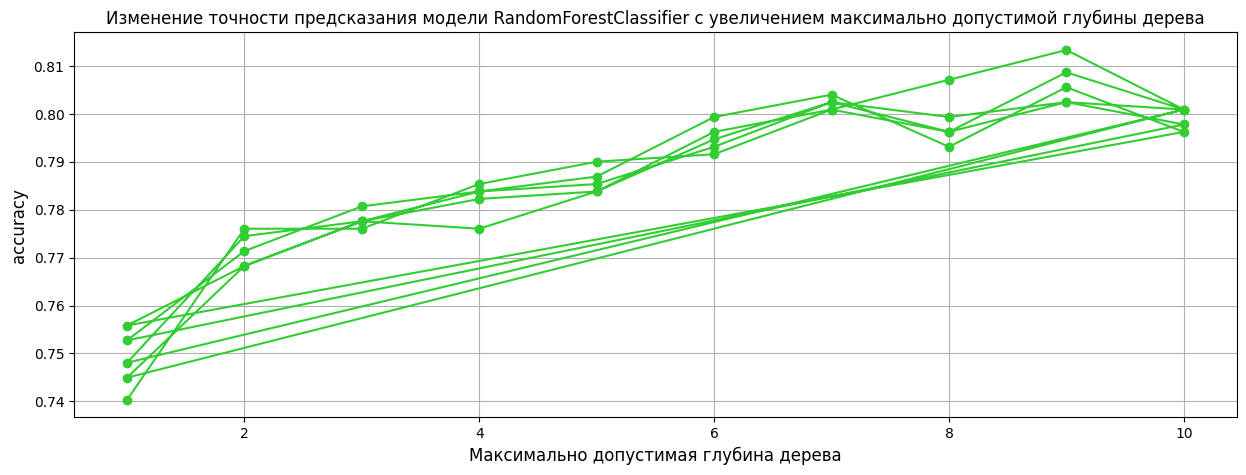

In [17]:
gparms_tree.plot(x='max_depth', y='accuracy', style='o-', color='limegreen', grid=True, figsize=(15,5), legend=False)
plt.title('Изменение точности предсказания модели RandomForestClassifier с увеличением максимально допустимой глубины дерева')
plt.xlabel('Максимально допустимая глубина дерева', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.show()

Чем глубже дерево, тем выше доля правильных ответов.

## Проверка модели на тестовой выборке:

In [18]:
predictions_test = best_model.predict(features_test) 
accuracy = accuracy_score(target_test, predictions_test) 
print(accuracy)

0.7853810264385692


В тестовой выборке accuracy чуть ниже, чем в валидационной, но также выше, чем 7.5, поэтому считаем, что тестовая выборка проверку прошла.

## Проверка модели на адекватность:

In [20]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent', random_state=0)

dummy_clf.fit(features_train, target_train)

dummy_clf.score(features_train, target_train)

0.6924273858921162

Качество моей модели выше, значит, она адекватна. 